In [1]:
import sys
sys.path.append('../../../scripts')
import analysis as an
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import copy

# Current Fleet - > LWR
- No power growth ( demand = 98.79 GWe for all years)
- No MOX, just UOX
    - Uranium Mine
    - Milling / Conversion
    - Enrichment
    - LWR Fuel Fabrication
    - Reactor (LWR)
    - Interim Storage (optional)
    - Permanent Disposal (Geological Repository)
- Legacy LWRs assumed to have 60-year lifetime
- Power shortage from decommissioned legacy LWRs filled by AP1000s
    - Electrical Power: 1100MWe
    - fuel batch mass 23.192 tons UO2
    - total core mass 69.576 tons UO2
    - Cycle time (refueling cycle) 18 months
    - Refueling outage 2 months
    - lifetime of 80 years
- Assuming 3.19% U235 enrichment for all UO2 fuel
- TIMESTEP IS A MONTH
- Total timestep: 1200 months (100 years)


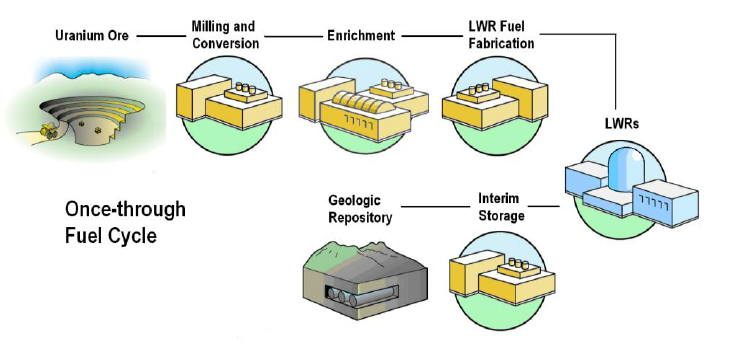

In [3]:
Image('../once_through.png')

# Explanation of metrics

`legacy_lwr_power`: Timeseries power capacity of legacy LWR reactors [MWe] 

`new_lwr_power`: Timeseries power capacity of new LWR reactors [MWe]

`exit_protos`: Names of reactors that gets decommissioned. Coincides iwth `exit_times`

`exit_times`: Times of the corresponding reactor in `exit_protos` decommissioning. [year_month]

`natl_u_raw`: Timeseries of natural uranium demand by reactors [MTHM / month]

`natl_u_smooth`: Timeseries of natural uranium demand smoothed out with average values [MTHM / month]

`legacy_discharge_rate`: Rate of legacy reactors discharging fuel [MTHM / 18 months]

`legacy_discharge_reactors`: Corresponding name of legacy reactors with discharge rate `legacy_discharge_rate`

`unf_discharge_raw`: Timeseries of UNF discharged by all reactors [MTHM /month]

`unf_discharge_smooth`: Timeseries of UNF discharged by all reactors smoothed out with average values [MTHM / month]

In [4]:
cur = an.cursor('increase_lwr.sqlite')
metric_dict = {}
init_year, init_month, duration, timestep = an.simulation_timesteps(cur)
years = init_year + init_month / 12 + timestep/12

In [5]:
# get total power capacity history
pow_cap = an.power_capacity(cur)
metric_dict['legacy_lwr_power'] = pow_cap['United States_government']
metric_dict['new_lwr_power'] = pow_cap['future_lwrs']
print(max(pow_cap['future_lwrs']))

# get lwrs deployed
x = cur.execute('SELECT * FROM agententry WHERE prototype == "ap1000"')
dep = np.zeros(duration)
for i in x:
    dep[i['entertime']] += 1


an.plot_power(cur)

267.51
Sink_Source_Inst has no values
Sink_Source_Inst has no values


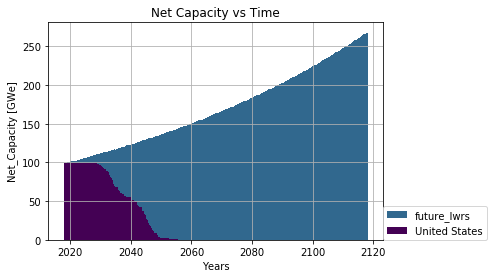

In [6]:
Image('power_plot.png')

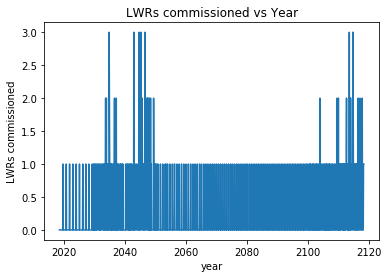

In [7]:
plt.plot(years, dep)
plt.xlabel('year')
plt.ylabel('LWRs commissioned')
plt.title('LWRs commissioned vs Year')
plt.show()
plt.close()

In [8]:
# get lwrs decommissioned

x = cur.execute('SELECT * FROM agentexit INNER join agententry WHERE agententry.agentid == agentexit.agentid').fetchall()
dep = np.zeros(duration)
exit_protos = []
exit_times = []
for i in x:
    exit_protos.append(i['prototype'])
    month = i['exittime']%12
    if month == 0:
        month = 12
    exit_times.append(str(2018 + i['exittime']//12) + '_' + str(month))
metric_dict['exit_protos'] = exit_protos
metric_dict['exit_times'] = exit_times


## Natural Uranium demand is a a series of spikes in the beginning because all legacy reactors act in sync (all have the exact same month of recycling and fuel demand)

`natl_u_raw` is the raw data from the simulation
`natl_u_smooth` is the data average over 18 months



1761912.095


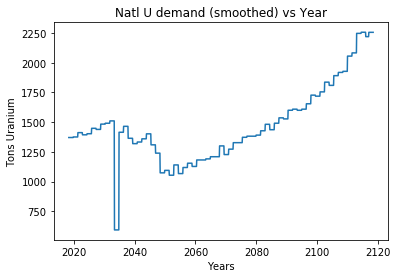

In [9]:
# uranium mined
nat_u = an.nat_u_timeseries(cur, is_cum=False)
nat_u[1] = nat_u[1]/3
metric_dict['natl_u_raw'] = nat_u
nat_u_smooth = np.array(copy.deepcopy(nat_u))
print(sum(nat_u))
for i in range(len(nat_u) // 18):
    nat_u_smooth[18*i:18*(i+1)] = np.mean(nat_u[18*i:18*(i+1)])
nat_u_smooth[-18:] = np.mean(nat_u[-18:])
plt.plot(years, nat_u_smooth)
plt.xlabel('Years')
plt.ylabel('Tons Uranium')
plt.title('Natl U demand (smoothed) vs Year')
metric_dict['natl_u_smooth'] = nat_u_smooth

In [10]:
# per-cycle fuel discharge mass for all legacy reactors
agent_id_dict = {}
x = cur.execute('SELECT * FROM agententry WHERE prototype != "ap1000" and "spec" == ":cycamore:Reactor"').fetchall()
for i in x:
    agent_id_dict[i['prototype']] = i['agentid']
legacy_discharge_rate = {}
for key, val in agent_id_dict.items():
    x = cur.execute('SELECT sum(quantity) FROM transactions INNER JOIN resources ON transactions.resourceid = resources.resourceID where senderid == %s GROUP BY time' %val).fetchone()
    legacy_discharge_rate[key] = x['sum(quantity)']


In [11]:
metric_dict['legacy_discharge_rate'] = np.array(list(legacy_discharge_rate.values()))
metric_dict['legacy_discharge_reactors'] = np.array(list(legacy_discharge_rate.keys()))

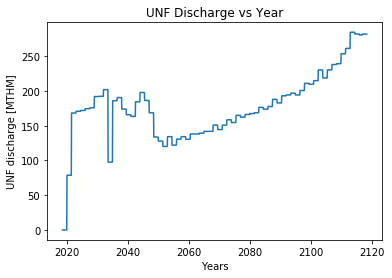

In [12]:
# UNF discharge
sink_id = an.agent_ids(cur, 'Sink')
unf_discharge = an.facility_commodity_flux(cur, sink_id, ['uox_waste'], False, False)['uox_waste']
unf_discharge_smooth = np.array(copy.deepcopy(unf_discharge))
for i in range(len(unf_discharge_smooth) // 18):
    unf_discharge_smooth[18*i:18*(i+1)] = np.mean(unf_discharge[18*i:18*(i+1)])
unf_discharge_smooth[-18:] = np.mean(unf_discharge[-18:])
plt.plot(years, unf_discharge_smooth)
plt.xlabel('Years')
plt.ylabel('UNF discharge [MTHM]')
plt.title('UNF Discharge vs Year')
plt.show()
plt.close()
metric_dict['unf_discharge_raw'] = unf_discharge
metric_dict['unf_discharge_smooth'] = unf_discharge_smooth

In [13]:
import pandas as pd
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in metric_dict.items() ]))
df.to_csv('test.csv', ',')